In [1]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif

# Model evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report

In [2]:
# Read data
def read_data(filename):
    base_path = "../Data/process/"
    return pd.read_csv(base_path + filename + '.csv')

In [3]:
X_train = read_data('X_train')
y_train = read_data('y_train')['churn']

# Validation dataset
X_val = read_data('X_validation')
y_val = read_data('y_validation')['churn']

In [4]:
def get_cv_scores(models, X, y, Kfold=10):

    # Create a stratified k-fold object.
    stratified_kfold = StratifiedKFold(n_splits=Kfold, shuffle=True, random_state=42)

    # Perform cross-validation
    score_list = []
    for name, clf in models.items():
        scores = cross_validate(estimator=clf, 
                                X=X, 
                                y=y, 
                                cv=stratified_kfold,
                                scoring=('accuracy', 'f1_macro'),
                                return_train_score=True,
                                n_jobs=-1)

        # Training Scores
        train_accuracy = scores['train_accuracy'].mean()
        train_f1_score, train_std = scores['train_f1_macro'].mean(), scores['train_f1_macro'].std()

        # Test Scores
        test_accuracy = scores['test_accuracy'].mean()
        test_f1_score, test_std = scores['test_f1_macro'].mean(), scores['test_f1_macro'].std()

        score_list.append((name, train_accuracy, test_accuracy, train_f1_score, train_std, test_f1_score, test_std))
        print(f"{name} --> {test_f1_score:.3f} +- {test_std:.3f}")

    
    # Create a score dataframe
    
    names = ['model', 'train_accuracy', 'test_accuracy', 'train_f1_score', 'train_std', 'test_f1_score', 'test_std']
    score_df = pd.DataFrame(score_list, columns=names)
    score_df.set_index('model', inplace=True)
    return score_df
        

In [5]:
# Model selection of base estimator
models = {
    'LR': LogisticRegression(),
    'Tree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'Kneighbors': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB(),
    'SVC': SVC(random_state=42),
    'XGBoostClf': XGBClassifier(random_state=42)
}

In [6]:
score_df = get_cv_scores(models, X_train, y_train)
score_df.style.highlight_max(['test_f1_score'], color='red', axis=0)

LR --> 0.634 +- 0.019
Tree --> 0.674 +- 0.019
RandomForest --> 0.725 +- 0.029
Kneighbors --> 0.688 +- 0.020
NaiveBayes --> 0.642 +- 0.148
SVC --> 0.684 +- 0.021
XGBoostClf --> 0.718 +- 0.020


,train_accuracy,test_accuracy,train_f1_score,train_std,test_f1_score,test_std
model,,,,,,
LR,0.815852,0.814857,0.635044,0.002386,0.633581,0.019210
Tree,1.000000,0.777524,1.000000,0.000000,0.673706,0.019115
RandomForest,0.999958,0.844381,0.999936,0.000191,0.725179,0.028825
Kneighbors,0.867492,0.819619,0.774470,0.004935,0.688135,0.020357
NaiveBayes,0.728190,0.727238,0.643778,0.148499,0.641967,0.148448
SVC,0.851238,0.839048,0.709304,0.003984,0.683612,0.021243
XGBoostClf,0.975810,0.834857,0.962261,0.004069,0.718241,0.020126


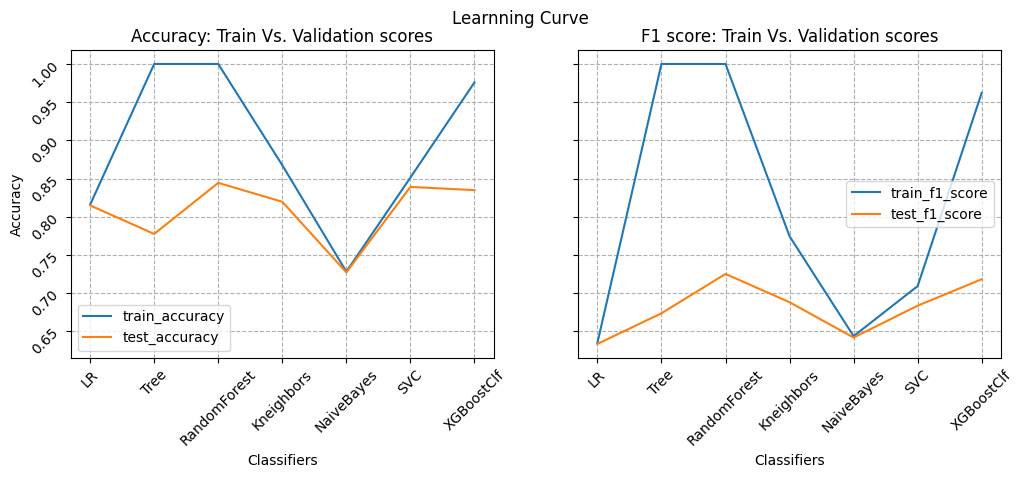

In [7]:
# Learning curve
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)

score_df.iloc[:, [0, 1]].plot(kind='line',
                              ax=ax1,
                              title='Accuracy: Train Vs. Validation scores',
                              xlabel='Classifiers', ylabel='Accuracy')

score_df.iloc[:, [2, 4]].plot(kind='line',
                              ax=ax2,
                              title='F1 score: Train Vs. Validation scores',
                              xlabel='Classifiers', ylabel='Precision_score')

# set grids
ax1.grid(ls='--')
ax2.grid(ls='--')

# Rotate the labels
ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)

fig.suptitle('Learnning Curve', size=12)
plt.show()

- *F1 scores is selected to measure the performace of the model as the data set is highly imbalanced and we want the model that produce high precision and recall scores.*
- *Random forest classifier has high f1score. However, overfitting can observed in tree-based classifiers with perfect score for training data.*

Let's calculate the mutual information score on features and select the top 10 features and then again observed the cross validation scores.

In [8]:
# Calculate the mutual information to find top 10 features.
mi_score = mutual_info_classif(X_train, y_train)
top_10_features = pd.Series(mi_score, index=X_train.columns).sort_values(ascending=False)[:10].index.tolist()

In [9]:
X_train[top_10_features].head()

,num_scaler__num_of_products,cat_oh_en__age_group_48-62,cat_oh_en__age_group_18-32,cat_oh_en__geography_germany,cat_oh_en__gender_female,remainder__is_active_member,num_scaler__salary,num_scaler__balance,cat_oh_en__geography_spain,cat_oh_en__gender_male
0,-0.903049,0.0,1.0,0.0,1.0,1.0,-0.285113,0.401538,1.0,0.0
1,2.501625,0.0,0.0,0.0,1.0,0.0,0.950511,-1.212180,1.0,0.0
2,-0.903049,0.0,0.0,1.0,0.0,1.0,-0.863601,0.990397,0.0,1.0
3,0.799288,0.0,1.0,0.0,1.0,0.0,-0.944384,-1.212180,1.0,0.0
4,-0.903049,0.0,0.0,0.0,0.0,0.0,1.420959,1.371400,0.0,1.0


In [10]:
# Trained a model again with top10 features.
score_df = get_cv_scores(models, X_train[top_10_features], y_train)
score_df.style.highlight_max(['test_f1_score'], color='red', axis=0)

LR --> 0.634 +- 0.018
Tree --> 0.678 +- 0.024
RandomForest --> 0.708 +- 0.021
Kneighbors --> 0.714 +- 0.020
NaiveBayes --> 0.687 +- 0.013
SVC --> 0.689 +- 0.026
XGBoostClf --> 0.715 +- 0.028


,train_accuracy,test_accuracy,train_f1_score,train_std,test_f1_score,test_std
model,,,,,,
LR,0.816212,0.816571,0.632424,0.002566,0.634176,0.018146
Tree,1.000000,0.784381,1.000000,0.000000,0.677715,0.024374
RandomForest,0.999894,0.821714,0.999841,0.000213,0.707806,0.021461
Kneighbors,0.873418,0.828762,0.786752,0.003680,0.713726,0.019692
NaiveBayes,0.800868,0.800000,0.688719,0.001438,0.687090,0.013158
SVC,0.848952,0.841333,0.703393,0.003484,0.689415,0.025884
XGBoostClf,0.939534,0.830286,0.901594,0.004108,0.715102,0.027885


- *With top 10 features, there is no significant change in f1-score of the test data and overfitting model.*
- *Remember the data is highly imbalance. Hence, the overfitting can observed in training.*

Next, evaluate the model performance on balanced dataset. We will try these two techniques to balance our dataset.
- Adjusting class weights of label samples.
- Using oversampling and undersampling method.

In [11]:
# Calculate class weights manually
from collections import Counter

class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

print("Class Weights:", class_weights)

Class Weights: {0: 0.6339048539000242, 1: 2.3669972948602345}


In [12]:
# Method 1 - Adjusts the class_weights
estimators = {
    'KNN' : KNeighborsClassifier(n_neighbors=3),
    'RandomForest': RandomForestClassifier(max_depth=3, class_weight='balanced_subsample', random_state=42),
    'XGBoost': XGBClassifier(max_depth=3, class_weights='balanced', random_state=42)
}

# Perform cross-validation on tree based algorithms
score_df = get_cv_scores(estimators, X_train, y_train)
score_df.style.highlight_max(['test_f1_score'], color='red', axis=0)

KNN --> 0.688 +- 0.031
RandomForest --> 0.700 +- 0.014
XGBoost --> 0.738 +- 0.026


,train_accuracy,test_accuracy,train_f1_score,train_std,test_f1_score,test_std
model,,,,,,
KNN,0.886984,0.812000,0.813834,0.003344,0.688481,0.030513
RandomForest,0.775386,0.771810,0.705623,0.002126,0.700435,0.013742
XGBoost,0.886286,0.850476,0.802020,0.004654,0.738069,0.025945


- *We can see that adjusting the class weight, the score of Xgboost classifier is improves but overfit the model.*
- *The performance of knn reduces, and it still overfit the data.*
- *The f1score of random forest reduces, But it no longer overfit the model.*

Next, we will try second method - Resampling.

In [13]:
# Method 2 - Resampling technique - Oversampling & Undersampling class examples.
# Using imblearn library
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Resampling class labels
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# Add random sample into the data
X_train_o_resample, y_train_o_resample = oversampler.fit_resample(X_train, y_train)
X_train_resample, y_train_resample = undersampler.fit_resample(X_train_o_resample, y_train_o_resample)

In [14]:
# Evaluate the performance of the tree based estimators on oversampling datasets.
score_df = get_cv_scores(estimators, X_train_resample, y_train_resample)
score_df.style.highlight_max(['test_f1_score'], color='red')

KNN --> 0.860 +- 0.010
RandomForest --> 0.734 +- 0.014
XGBoost --> 0.816 +- 0.010


,train_accuracy,test_accuracy,train_f1_score,train_std,test_f1_score,test_std
model,,,,,,
KNN,0.927460,0.860541,0.927190,0.000842,0.859513,0.009721
RandomForest,0.736510,0.734968,0.735475,0.004602,0.733859,0.013785
XGBoost,0.849969,0.815986,0.849967,0.002877,0.815923,0.010000


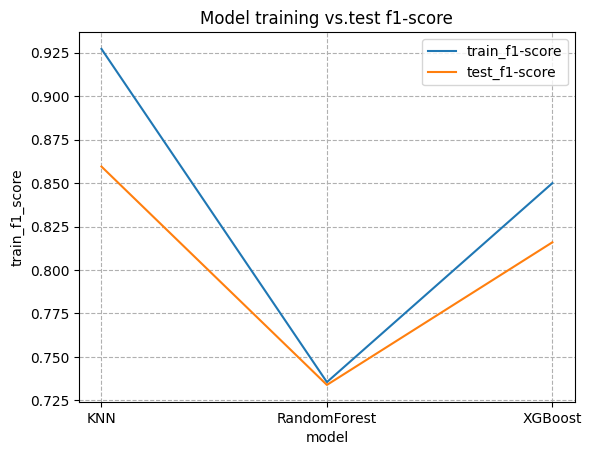

In [15]:
# Plot the results
sns.lineplot(score_df['train_f1_score'], label='train_f1-score')
sns.lineplot(score_df['test_f1_score'], label='test_f1-score')

plt.title('Model training vs.test f1-score')
plt.grid(ls='--')
plt.show()

- *Resampling improves the accuracy of all estimators significantly.*
- *The score of Xgboost classifier increases from 0.73 to 0.81, for RandomForest classifier its from 0.70 to 0.73, and for knn its from 0.68 to 0.85*
- *The K-nearest neighbors model performance improves significantly, however model is overfitted, as you can see in the above plot that the difference between training and test scores is large for both knn and xgbclassifier.*
- *The Random Forest classifier shows the little to no difference in scores, so we will select the it for further evaluations.*

#### Hyperparameter tunning

In [17]:
# Hyper tunning parameter of the SVC
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Define the parameter grid
param_grid = {
    'n_estimators': range(100, 500, 50),
    'max_depth': [3, 5, 7, 9],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 5, 10]
}

# Define startified k-fold for svc
stratified_kfold = StratifiedKFold(shuffle=True, random_state=True)

# Create xgboost classifier model.
rf_clf = RandomForestClassifier(class_weight='balanced',
                                random_state=42,
                                n_jobs=-1)

# Create a GridSearchCV object
grid_search = GridSearchCV(rf_clf,
                           param_grid,
                           scoring='f1_macro',
                           refit=True,
                           cv=stratified_kfold,
                           return_train_score=True
                           )
   
# Fit the model
grid_search.fit(X_train_resample, y_train_resample)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=True, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': range(100, 500, 50)},
             return_train_score=True, scoring='f1_macro')

In [18]:
print(grid_search.best_params_)
scores = pd.DataFrame(grid_search.cv_results_)

{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


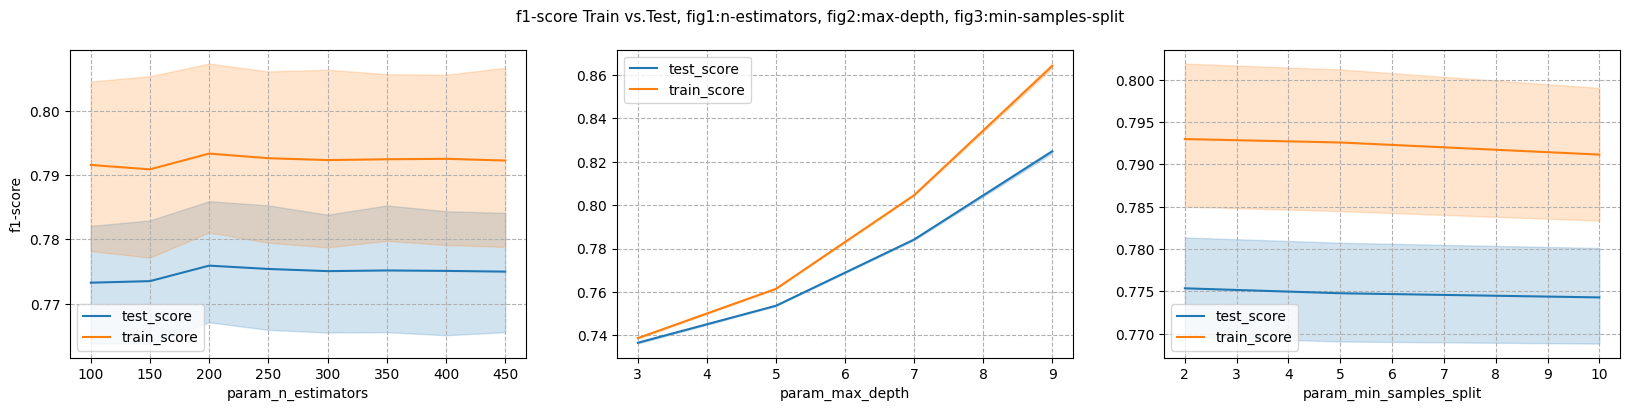

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

sns.lineplot(x=scores['param_n_estimators'], y=scores['mean_test_score'], label='test_score', ax=ax1)
sns.lineplot(x=scores['param_n_estimators'], y=scores['mean_train_score'], label='train_score', ax=ax1)

sns.lineplot(x=scores['param_max_depth'], y=scores['mean_test_score'], label='test_score', ax=ax2)
sns.lineplot(x=scores['param_max_depth'], y=scores['mean_train_score'], label='train_score', ax=ax2)

sns.lineplot(x=scores['param_min_samples_split'], y=scores['mean_test_score'], label='test_score', ax=ax3)
sns.lineplot(x=scores['param_min_samples_split'], y=scores['mean_train_score'], label='train_score', ax=ax3)

ax1.set_ylabel('f1-score')
ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.grid(ls='--')
ax2.grid(ls='--')
ax3.grid(ls='--')

fig.suptitle('f1-score Train vs.Test, fig1:n-estimators, fig2:max-depth, fig3:min-samples-split', size=11)
plt.show()

- *The above line plots shows the f1-scores for training and test data for different values of parameters.*
- *The first figure shows the scores for n-estimators parameter, there is no increament in accuracy after 200.*
- *In second figure, as the depth of tree increases there is increament in scores for both training and test data. However, it also leads to overfitting model.*
- *In last figure, you can see that as the number of samples split increases the scores descreases.*

Let's save the best model, and evaluate the performance on validation data.

In [22]:
# Save the best model object
import pickle
with open('../Model/grid_search_best_model.pkl', 'wb') as f:
    best_model = grid_search.best_estimator_
    pickle.dump((grid_search, best_model), f)

In [23]:
def get_score(y_true, y_preds):

    # Compute scores
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1score = f1_score(y_true, y_preds)
    report = classification_report(y_true, y_preds)

    return accuracy, precision, recall, f1score, report

In [24]:
# Evaluate the model performance on validation score
best_model.fit(X_train_resample, y_train_resample)
y_predict_proba = best_model.predict_proba(X_val)[:, 1]
y_preds = (y_predict_proba > 0.5).astype('int')

# Compute scores
accuracy, precision, recall, f1score, report = get_score(y_val, y_preds) 
print("accuracy: %.3f" %accuracy)
print("precision: %.3f" %precision)
print("recall: %.3f" %recall)
print("f1score: %.3f" %f1score)

print(report) 

accuracy: 0.794
precision: 0.483
recall: 0.654
f1score: 0.556
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1406
           1       0.48      0.65      0.56       344

    accuracy                           0.79      1750
   macro avg       0.70      0.74      0.71      1750
weighted avg       0.82      0.79      0.81      1750



In [31]:
y_train_preds = best_model.predict(X_train_resample)

# Compute scores
accuracy, precision, recall, f1score, report = get_score(y_train_resample, y_train_preds) 
print("accuracy: %.3f" %accuracy)
print("precision: %.3f" %precision)
print("recall: %.3f" %recall)
print("f1score: %.3f" %f1score)

print(report) 

accuracy: 0.871
precision: 0.869
recall: 0.872
f1score: 0.871
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4141
           1       0.87      0.87      0.87      4141

    accuracy                           0.87      8282
   macro avg       0.87      0.87      0.87      8282
weighted avg       0.87      0.87      0.87      8282



- *The model seems to overfitted. Its not performing good on validation data. Let's not consider that model for further evalutions.*

In [42]:
# Create a new model
random_clf = RandomForestClassifier(n_estimators=180, criterion='entropy', max_depth=9, class_weight='balanced', random_state=42)

random_clf.fit(X_train_resample, y_train_resample)
y_predict_proba = random_clf.predict_proba(X_val)[:, 1]
y_preds = (y_predict_proba > 0.5).astype('int')

# Compute scores
accuracy, precision, recall, f1score, report = get_score(y_val, y_preds) 
print("accuracy: %.3f" %accuracy)
print("precision: %.3f" %precision)
print("recall: %.3f" %recall)
print("f1score: %.3f" %f1score)

print(report) 
        

accuracy: 0.786
precision: 0.468
recall: 0.651
f1score: 0.544
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1406
           1       0.47      0.65      0.54       344

    accuracy                           0.79      1750
   macro avg       0.69      0.73      0.70      1750
weighted avg       0.82      0.79      0.80      1750



In [38]:
# Training data
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

# Read the test data.
X_test = read_data('X_test')
y_test = read_data('y_test')['churn']

In [54]:
# Evaluate the model on test data
final_model = RandomForestClassifier(n_estimators=350,
                                    criterion='entropy', 
                                    max_depth=9, 
                                    class_weight='balanced',
                                    random_state=42)

# fit the final model on training data
final_model.fit(X_full_train, y_full_train)

# Make predictions on training data
y_preds_train = final_model.predict(X_full_train)

# Make predictions on test data
y_preds = final_model.predict(X_test)

# Calculate the precision score
train_score = precision_score(y_full_train, y_preds_train)
final_score = precision_score(y_test, y_preds)

print("Train score: %.3f" %train_score)
print("final model score: %.3f" %final_score)

Train score: 0.634
final model score: 0.605


In [55]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      1406
           1       0.61      0.74      0.66       344

    accuracy                           0.85      1750
   macro avg       0.77      0.81      0.79      1750
weighted avg       0.87      0.85      0.86      1750



- *The precision accuracy score on test data is 0.61, with recall 0.74, with f1-score 0.66*

In [57]:
# Save the final model
with open('../Model/final_rf_clf.bin', 'wb') as f:
    pickle.dump(final_model, f)